<a id='sommaire'></a>
<h1 style='text-align:center;border:5px double;border-color:gray;'>
    <br/>
    PROJET 9<br/>
    <br/>
    "Prédisez la demande en électricité"
    <br/>
    <br/>
    Script 1
    <br/>
</h1>

In [1]:
#Chargement des bibliothèques
library(ggplot2)
library(forecast)
library(zoo)
library(latex2exp)
library(caschrono)
library(tseries)
library(astsa)
library(lmtest)


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘astsa’

The following object is masked from ‘package:forecast’:

    gas



In [2]:
#Création de fichier pour rangement des graphs
if (dir.exists('graph') != TRUE){
    dir.create('graph')
}

if (dir.exists('graph/representation') != TRUE){
    dir.create('graph/representation')
}

if (dir.exists('graph/question_1') != TRUE){
    dir.create('graph/question_1')
}

if (dir.exists('graph/question_2') != TRUE){
    dir.create('graph/question_2')
}

if (dir.exists('graph/question_3') != TRUE){
    dir.create('graph/question_3')
}

# 1) Préparation des données

## 1) a) La consommation mensuelle en électricité

In [3]:
#Lecture du fichier téléchargé
conso_mens = read.csv('eCO2mix_RTE_energie_M.csv',
                      header=T,
                      dec='.',
                      sep=',',
                      fileEncoding='latin3')

#Restriction sur les données de la France, projection sur la consommation mensuelle
conso_mens = subset(conso_mens, conso_mens$Territoire == 'France', c(Mois, Consommation.totale))

#Modification du format de la date
conso_mens$Date = paste(conso_mens$Mois, '01', sep='-')

#Suppression de la première ligne
conso_mens = conso_mens[-1,]

#Déclaration du type date
conso_mens$Date = as.Date(conso_mens$Date, format=('%Y-%m-%d'))

#Restriction sur la période commune avec DJU
conso_mens = conso_mens[(conso_mens$Date >= '2010-01-01') & (conso_mens$Date < '2018-06-01'),]

#Mise en forme
names(conso_mens)[2] = 'Conso'

#Restriction
conso_mens = conso_mens[,-1]

head(conso_mens)

,Conso,Date
,<int>,<date>
14,56342,2010-01-01
15,48698,2010-02-01
16,48294,2010-03-01
17,38637,2010-04-01
18,37284,2010-05-01
19,34567,2010-06-01


## 1) b) Dégre Jour Unifié

In [4]:
#Lecture du fichier crée
dju_chauf = read.csv('dju_chauffage.csv')

#Mise en forme
names(dju_chauf)[1] = 'Annee'

dju_chauf

Annee,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,TOTAL
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,624.8,474.7,414.9,292.7,260.6,112.6,46.5,93.8,163.6,286.4,419.3,644.1,3833.8
2011,507.2,408.6,368.7,202.0,165.6,117.2,122.5,84.7,101.9,232.3,338.0,424.8,3073.4
2012,454.5,555.6,334.9,344.4,192.8,133.3,95.3,59.6,165.5,262.1,403.3,455.7,3456.9
2013,548.2,519.7,505.5,326.3,277.4,146.0,51.3,79.0,141.8,209.3,417.7,456.5,3678.6
2014,434.4,376.9,346.9,255.1,219.7,124.4,76.3,104.9,111.9,194.5,326.6,489.2,3060.6
2015,507.0,472.3,400.2,269.9,210.1,109.2,62.7,61.0,184.6,293.5,301.0,349.1,3220.5
2016,477.6,428.8,445.1,333.6,207.6,117.4,66.3,61.3,85.7,290.2,400.3,511.6,3425.4
2017,592.6,382.6,318.9,315.3,168.7,72.8,59.2,74.7,158.1,206.1,392.9,483.4,3225.2
2018,417.9,537.6,426.6,224.3,163.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA


In [5]:
#Lecture du fichier crée
dju_clim = read.csv('dju_clim.csv')

#Mise en forme
names(dju_clim)[1] = 'Annee'

dju_clim

Annee,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,TOTAL
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
2010,0,0,0.0,2.6,7.6,27.5,61.1,24.4,4.4,1.9,0,0,129.4
2011,0,0,0.1,7.8,10.8,27.7,11.7,28.8,26.8,6.3,0,0,120.0
2012,0,0,0.5,0.1,12.2,9.7,24.3,53.2,10.1,1.1,0,0,111.2
2013,0,0,0.0,2.9,0.0,12.4,68.7,40.9,12.1,0.8,0,0,137.9
2014,0,0,0.0,0.3,1.4,13.2,43.1,10.5,15.3,3.1,0,0,86.9
2015,0,0,0.0,2.7,1.9,33.5,71.3,64.9,0.9,0.0,0,0,175.3
2016,0,0,0.0,0.0,4.0,12.4,44.9,63.5,30.9,0.1,0,0,155.7
2017,0,0,0.3,0.7,22.3,51.9,51.6,36.1,2.5,2.5,0,0,167.9
2018,0,0,0.0,9.3,17.9,0.0,0.0,0.0,0.0,0.0,0,0,27.2


In [6]:
#Addition des valeurs des dju pour le chauffage et la clim
dju2 = dju_chauf + dju_clim

#Rétablissement des années
dju2$Annee = dju2$Annee / 2

#Changement du nom des mois par le numéro
names(dju2) = c('Annee', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 'Total')

dju2

Annee,01,02,03,04,05,06,07,08,09,10,11,12,Total
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,624.8,474.7,414.9,295.3,268.2,140.1,107.6,118.2,168.0,288.3,419.3,644.1,3963.2
2011,507.2,408.6,368.8,209.8,176.4,144.9,134.2,113.5,128.7,238.6,338.0,424.8,3193.4
2012,454.5,555.6,335.4,344.5,205.0,143.0,119.6,112.8,175.6,263.2,403.3,455.7,3568.1
2013,548.2,519.7,505.5,329.2,277.4,158.4,120.0,119.9,153.9,210.1,417.7,456.5,3816.5
2014,434.4,376.9,346.9,255.4,221.1,137.6,119.4,115.4,127.2,197.6,326.6,489.2,3147.5
2015,507.0,472.3,400.2,272.6,212.0,142.7,134.0,125.9,185.5,293.5,301.0,349.1,3395.8
2016,477.6,428.8,445.1,333.6,211.6,129.8,111.2,124.8,116.6,290.3,400.3,511.6,3581.1
2017,592.6,382.6,319.2,316.0,191.0,124.7,110.8,110.8,160.6,208.6,392.9,483.4,3393.1
2018,417.9,537.6,426.6,233.6,180.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA


In [7]:
#Création des listes
valeurs = list()
noms = list()

#Boucle pour obtenir les valeurs et les nom (dates)
for (i in 2:13)
    {
    valeurs = append(valeurs, c(dju2[,i]))
    for (j in 1:9) 
        {
        noms = append(noms, paste(dju2[j, 1], names(dju2[i]), '01', sep='-'))
    }
}

#Transformation des listes en vecteurs
noms = unlist(noms)
valeurs = unlist(valeurs)

#Création du Dataframe
dju = data.frame(dju=valeurs, Date=noms)

#Déclaration du type date
dju$Date = as.Date(dju$Date, format=('%Y-%m-%d'))

#Tri du dataframe par date croissante
dju = dju[order(dju$Date),]

#Restriction sur la période valide
dju = dju[(dju$Date >= '2010-01-01') & (dju$Date < '2018-06-01'),]

head(dju)

,dju,Date
,<dbl>,<date>
1,624.8,2010-01-01
10,474.7,2010-02-01
19,414.9,2010-03-01
28,295.3,2010-04-01
37,268.2,2010-05-01
46,140.1,2010-06-01


## 1) c) Jointure de conso et dju

In [8]:
#Jointure
conso = merge(x=conso_mens, y=dju, by='Date')

head(conso)

Date,Conso,dju
<date>,<int>,<dbl>
2010-01-01,56342,624.8
2010-02-01,48698,474.7
2010-03-01,48294,414.9
2010-04-01,38637,295.3
2010-05-01,37284,268.2
2010-06-01,34567,140.1


## 1) d) Représentation graphique

Saving 6,67 x 6,67 in image


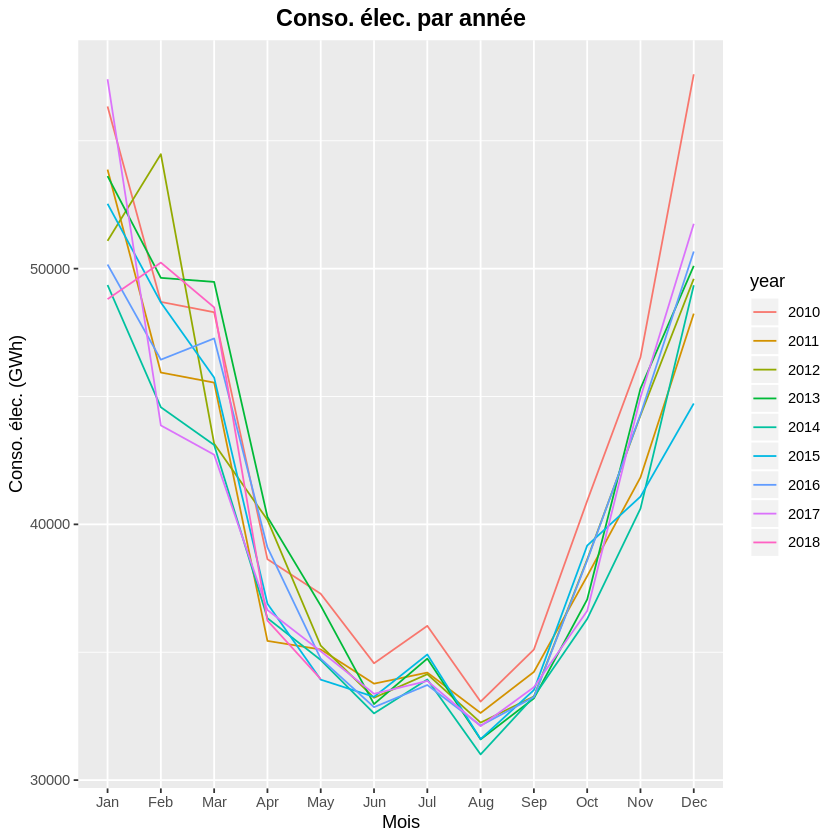

In [9]:
#Création de la time serie consommation électrique
conso.ts = ts(conso$Conso, start=2010, end=c(2018,5), freq=12)

#Graphique de la conso élec par année (sur un seul un graphique)
ggseasonplot(conso.ts) + 
xlab('Mois') +
ylab('Conso. élec. (GWh)') +
labs(title='Conso. élec. par année') +
theme(plot.title = element_text(size=14, face="bold", hjust=0.5))

ggsave('graph/representation/conso_annee_multi.png')

Saving 6,67 x 6,67 in image


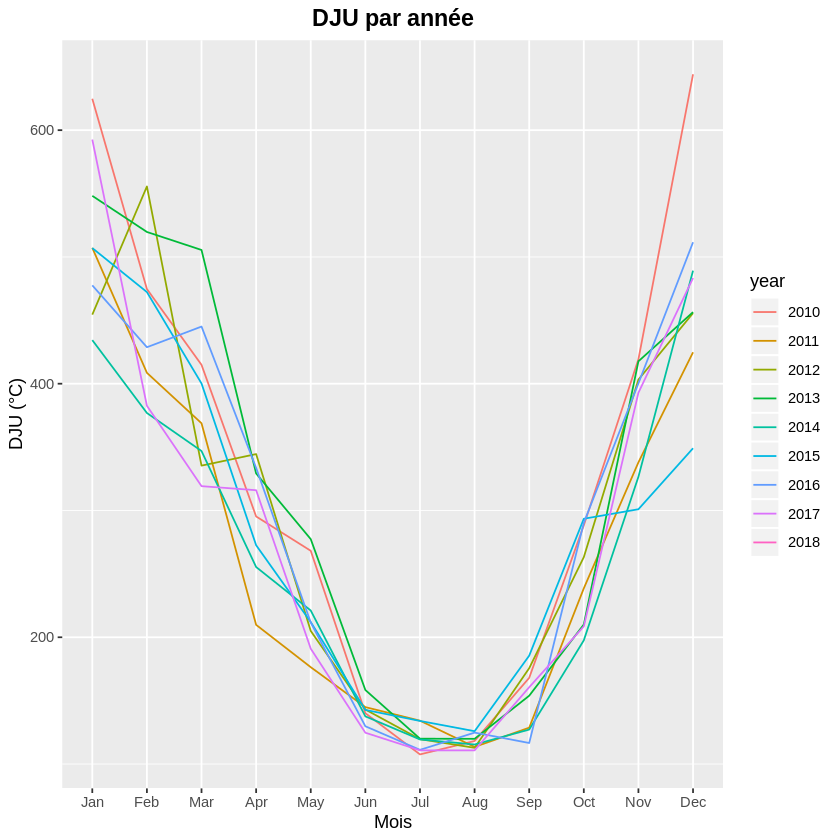

In [10]:
#Création de la time serie dju
dju.ts = ts(conso$dju, start=2010, end=2018, freq=12)

#Graphique des DJU par année (sur un seul un graphique)
ggseasonplot(dju.ts) + 
xlab('Mois') +
ylab('DJU (°C)') +
labs(title='DJU par année') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5))

ggsave('graph/representation/dju_multi.png')

Saving 6,67 x 6,67 in image


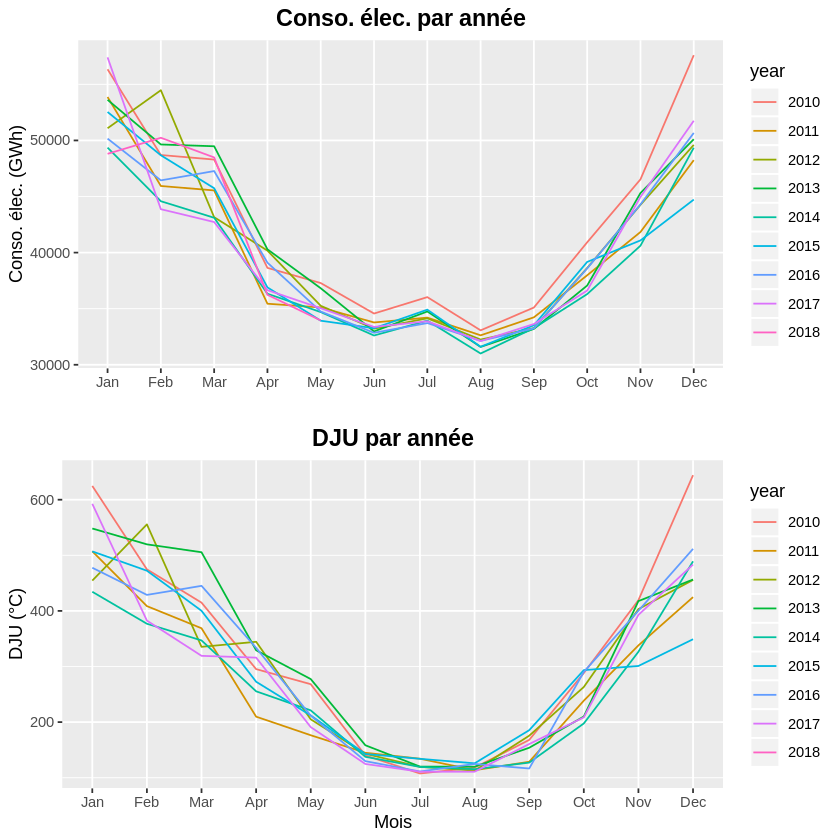

In [11]:
#Graphique de la consommation électrique et des DJU par année (sur un seul un graphique)
d1 = ggseasonplot(conso.ts) + 
xlab('') +
ylab('Conso. élec. (GWh)') +
labs(title='Conso. élec. par année') +
theme(plot.title = element_text(size=14, face="bold", hjust=0.5))

d2 = ggseasonplot(dju.ts) + 
xlab('Mois') +
ylab('DJU (°C)') +
labs(title='DJU par année') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5))

library(gridExtra)
d3 =grid.arrange(d1, d2, nrow = 2)

ggsave('graph/representation/conso_dju_multi.png', d3)

Saving 6,67 x 6,67 in image


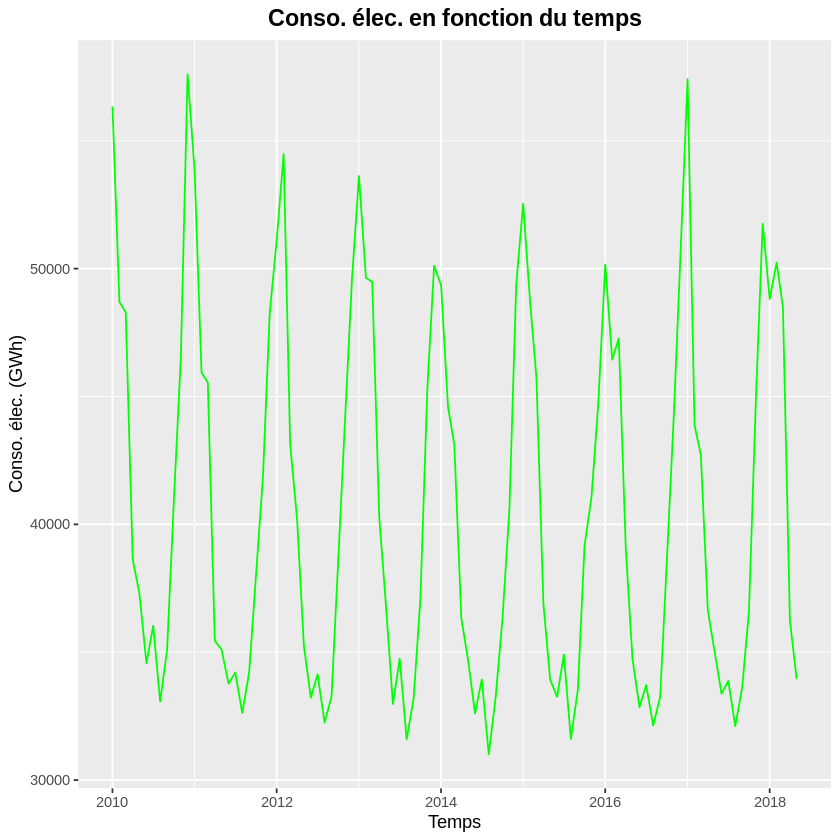

In [12]:
#Représentation de la conso de Janvier 2010 à Mai 2018
ggplot(conso) +
geom_line(aes(Date, Conso), colour="green") +
ggtitle('Conso. élec. en fonction du temps') +
xlab('Temps') +
ylab('Conso. élec. (GWh)') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5))

ggsave('graph/representation/conso.png')

Saving 6,67 x 6,67 in image


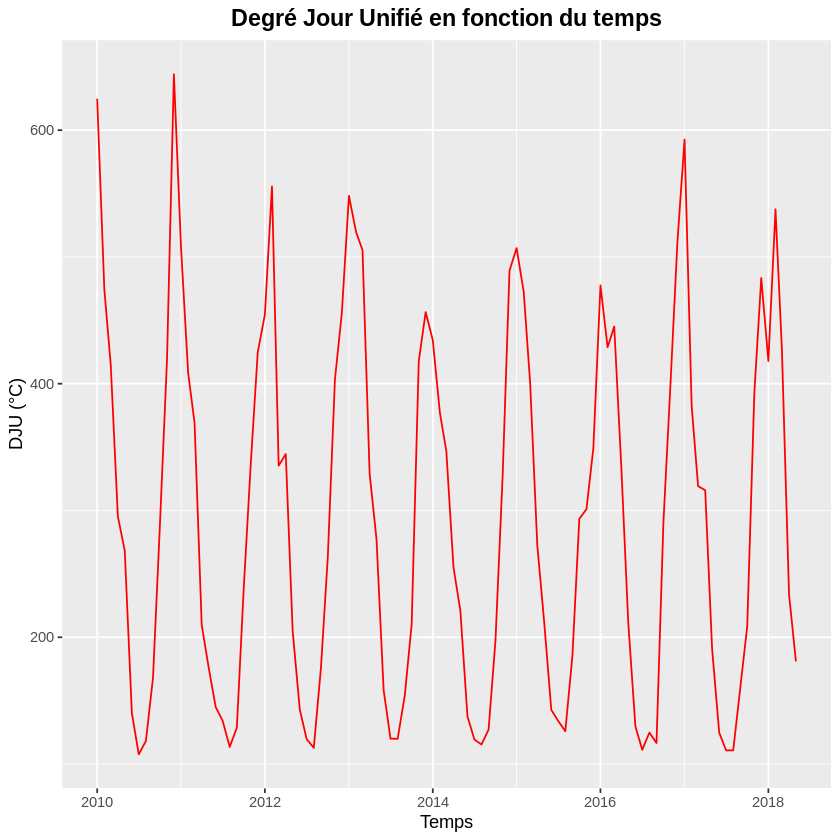

In [13]:
#Représentation des DJU de Janvier 2010 à Mai 2018
ggplot(conso) + 
geom_line(aes(Date, dju), colour ='red') +
ggtitle('Degré Jour Unifié en fonction du temps') +
xlab('Temps') +
ylab('DJU (°C)') + theme(plot.title = element_text(size=14, face='bold', hjust=0.5))

ggsave('graph/representation/dju.png')

Saving 6,67 x 6,67 in image


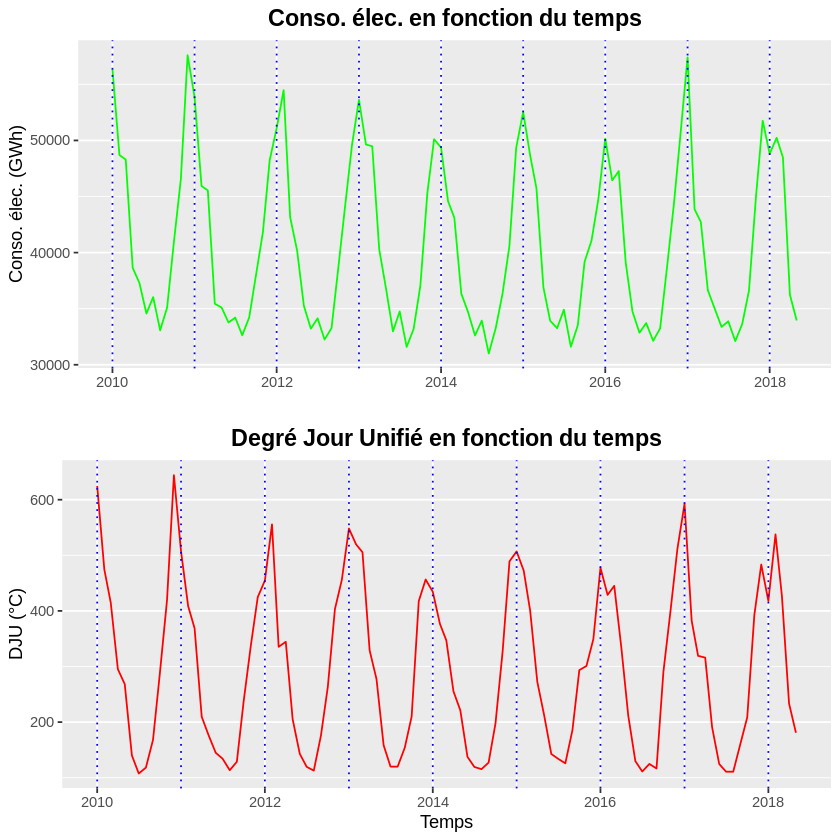

In [14]:
#Représentation de la conso et des DJU l'un en dessous de l'autre
p = ggplot(conso) +
geom_line(aes(Date, Conso), colour='green') + 
ggtitle('Conso. élec. en fonction du temps') +
xlab('') +
ylab('Conso. élec. (GWh)') +
theme(plot.title = element_text(size=14, face="bold", hjust=0.5)) +
geom_vline(aes(xintercept=as.numeric(conso$Date[1])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[13])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[25])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[37])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[49])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[61])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[73])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[85])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[97])), col='blue', linetype=3)

g = ggplot(conso) + 
geom_line(aes(Date, dju), colour ='red') +
ggtitle('Degré Jour Unifié en fonction du temps') +
xlab('Temps') +
ylab('DJU (°C)') + theme(plot.title = element_text(size=14, face="bold", hjust=0.5)) +
geom_vline(aes(xintercept=as.numeric(conso$Date[1])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[13])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[25])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[37])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[49])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[61])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[73])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[85])), col='blue', linetype=3) +
geom_vline(aes(xintercept=as.numeric(conso$Date[97])), col='blue', linetype=3)

library(gridExtra)
d =grid.arrange(p, g, nrow = 2)

ggsave('graph/representation/conso_dju.png', d)

# 2) Question 1: Désaisonnalisation par reg lin

Saving 6,67 x 6,67 in image


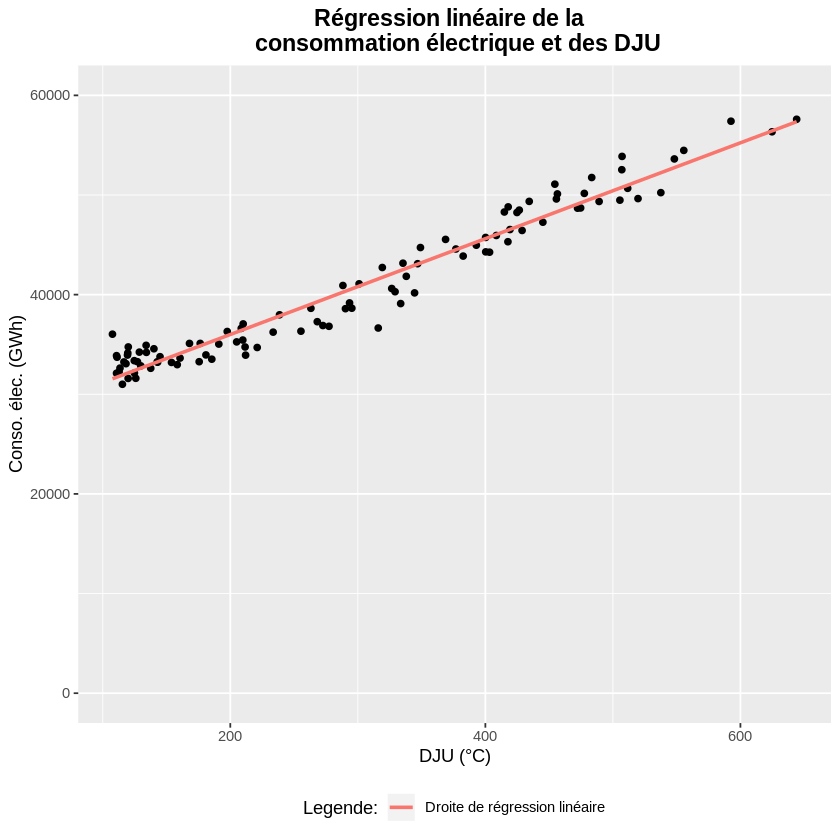

In [15]:
#Représentation de la conso en fonction des DJU pour régression linéaire
ggplot(conso, aes(x=dju, y=Conso)) +
geom_point() +
geom_smooth(method=lm, se=F, aes(colour='blue')) + 
ylim(0, 60000) +
scale_color_discrete(name='Legende:',
                    labels=c('Droite de régression linéaire')) +
ggtitle('Régression linéaire de la  \n consommation électrique et des DJU') +
xlab('DJU (°C)') +
ylab('Conso. élec. (GWh)') + 
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') 

ggsave('graph/question_1/reg_lin_conso_dju.png')

In [16]:
#Régression linéaire
u1 = conso$dju
u2 = conso$Conso

reg = lm(u2 ~ u1)

reg


Call:
lm(formula = u2 ~ u1)

Coefficients:
(Intercept)           u1  
    26380,2         48,1  


In [17]:
#Coefficient de corrélation linéaire
r2 = summary(reg)$r.squared
#Coefficient de détermination
R2 = summary(reg)$r.squared ^ 2
cat(' Coefficient de régression linéaire:', r2, '\n', 'Coefficient de détermination:', R2)

 Coefficient de régression linéaire: 0,9524547 
 Coefficient de détermination: 0,90717

In [18]:
#Coefficient directeur et ordonée à l'origine
coef = reg$coefficients[2]
ord_ori = reg$coefficients[1]

#Correction de la conso. élec. de l'effet de température
conso$Conso_RL = conso$Conso - coef*conso$dju

head(conso)

Date,Conso,dju,Conso_RL
<date>,<int>,<dbl>,<dbl>
2010-01-01,56342,"624,8","26291,76"
2010-02-01,48698,"474,7","25866,93"
2010-03-01,48294,"414,9","28339,06"
2010-04-01,38637,"295,3","24434,32"
2010-05-01,37284,"268,2","24384,71"
2010-06-01,34567,"140,1","27828,78"


png 
  2

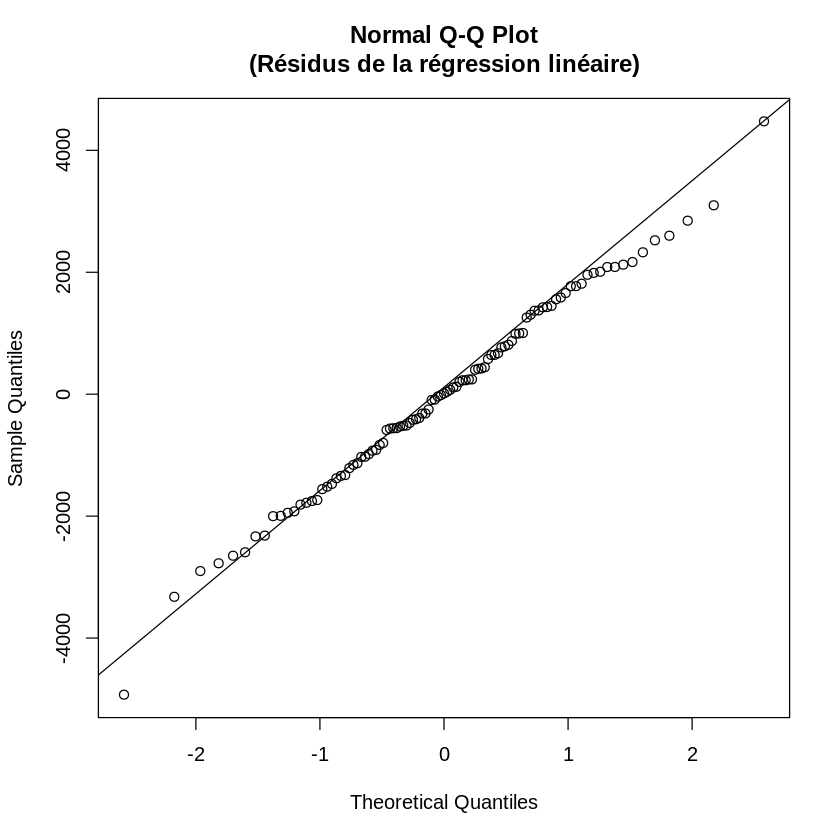

In [19]:
#Sauvegarde du graph
png('graph/question_1/qqplot_reg_lin.png')

reg.residuals = resid(reg)
qqnorm(reg.residuals, main='Normal Q-Q Plot\n(Résidus de la régression linéaire)')
qqline(reg.residuals)

dev.off()

#Représentation Quantile-Quantile des résidus
qqnorm(reg.residuals, main='Normal Q-Q Plot\n(Résidus de la régression linéaire)')
qqline(reg.residuals)

In [20]:
#Test de normalité des résidus
shapiro.test(reg.residuals)


	Shapiro-Wilk normality test

data:  reg.residuals
W = 0,99471, p-value = 0,9656


png 
  2

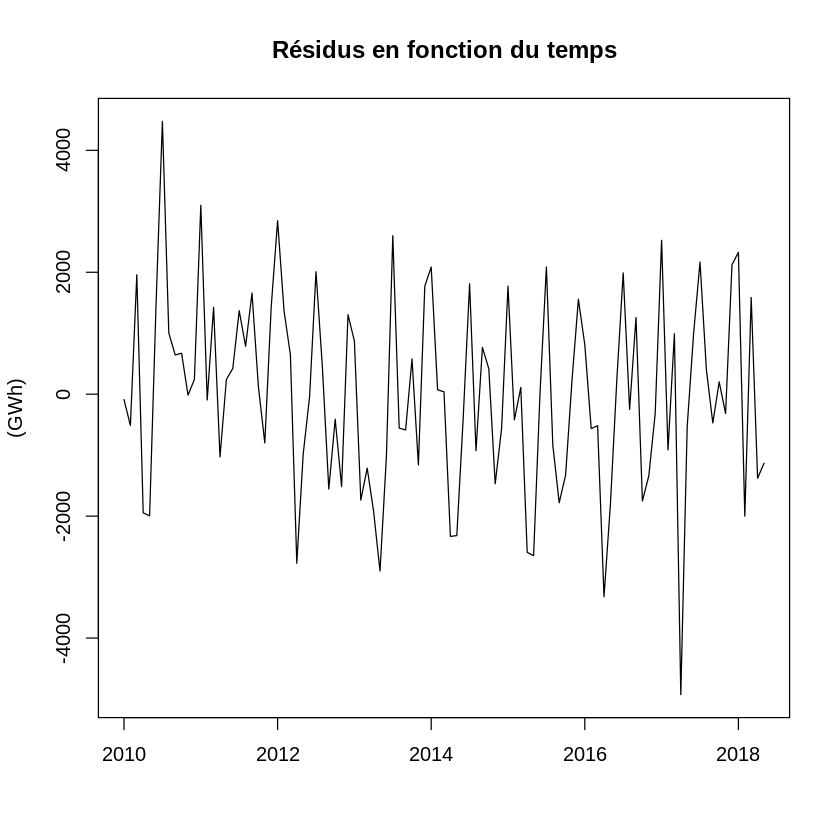

In [21]:
plot(ts(reg.residuals, start=2010, freq=12),
     type='l',
     main='Résidus en fonction du temps',
     ylab='(GWh)',
     xlab='')

#Sauvegarde du graph
png('graph/question_1/res_reg_lin.png')

plot(ts(reg.residuals, start=2010, freq=12),
     type='l',
     main='Résidus en fonction du temps',
     ylab='(GWh)',
     xlab='')

dev.off()

#Représentation Quantile-Quantile des résidus
plot(ts(reg.residuals, start=2010, freq=12),
     type='l',
     main='Résidus en fonction du temps',
     ylab='(GWh)',
     xlab='')

In [22]:
#Test de Breusch Pagan
bptest(reg)


	studentized Breusch-Pagan test

data:  reg
BP = 0,035977, df = 1, p-value = 0,8496


Saving 6,67 x 6,67 in image


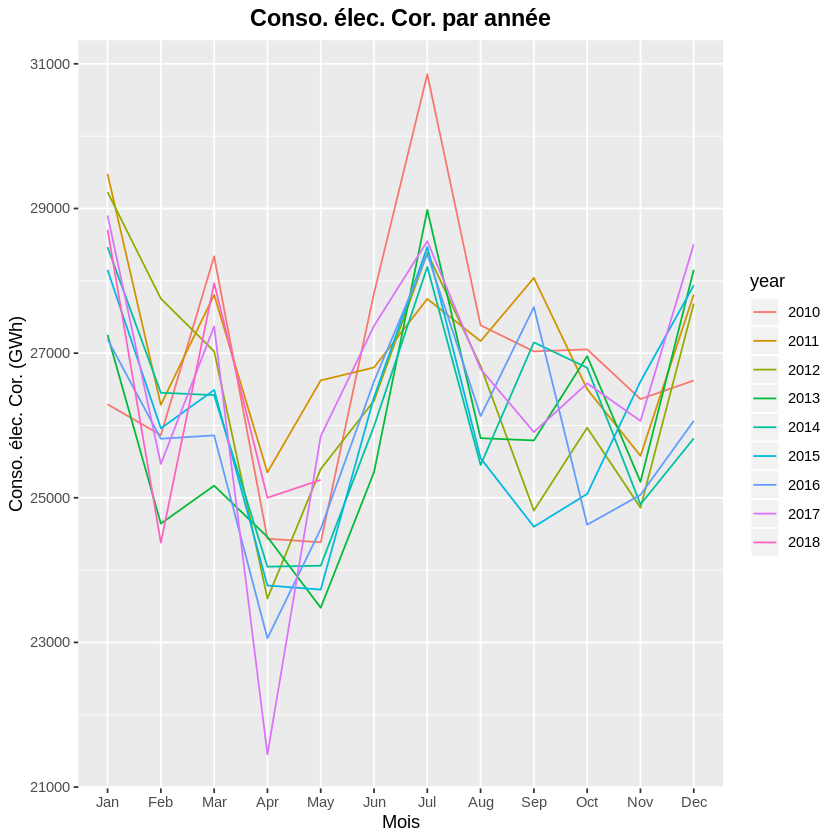

In [23]:
#Création de la time serie consommation électrique corrigée
conso_RL.ts = ts(conso$Conso_RL, start=2010, freq=12)

#Graphique de la conso. élec. cor. par année (sur un seul un graphique)
ggseasonplot(conso_RL.ts) + 
xlab('Mois') +
ylab('Conso. élec. Cor. (GWh)') +
labs(title='Conso. élec. Cor. par année') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5))

ggsave('graph/question_1/conso_cor_annee_multi.png')

Saving 6,67 x 6,67 in image


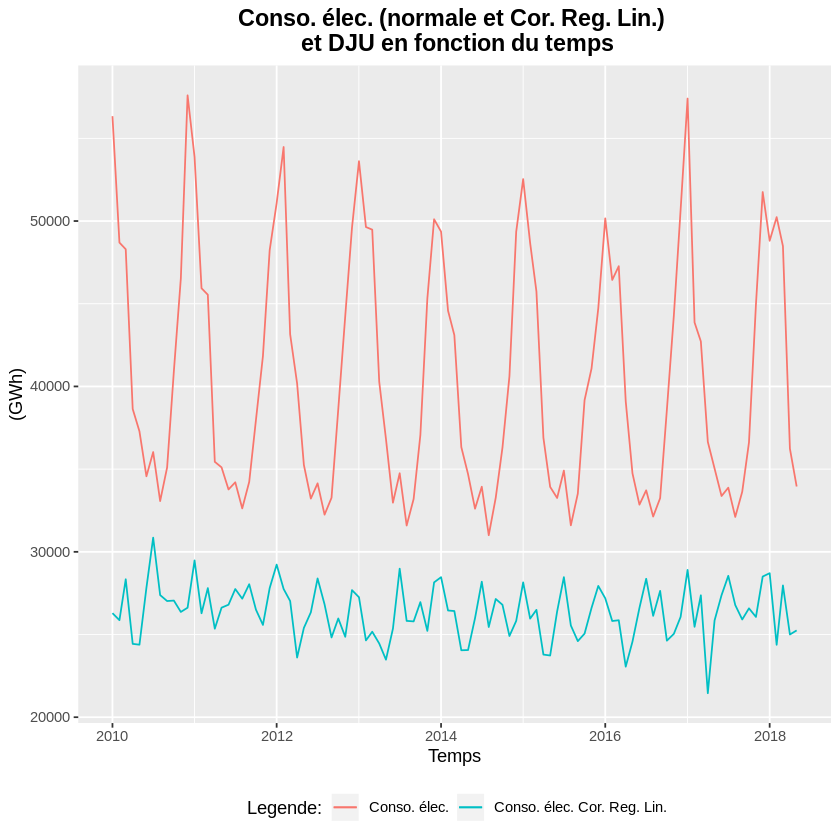

In [24]:
#Représentation de la conso, des DJU et de la conso corrigée de Janvier 2010 à Mai 2018
ggplot(conso) + 
geom_line(aes(Date, Conso, colour="A")) +
geom_line(aes(Date, Conso_RL, colour="C")) +
scale_color_discrete(name='Legende:',
                    labels=c('Conso. élec.', 'Conso. élec. Cor. Reg. Lin.')) +
ggtitle('Conso. élec. (normale et Cor. Reg. Lin.) \n et DJU en fonction du temps') +
xlab('Temps') +
ylab('(GWh)') + 
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') 



ggsave('graph/question_1/conso_et_conso_RL.png')

Saving 6,67 x 6,67 in image


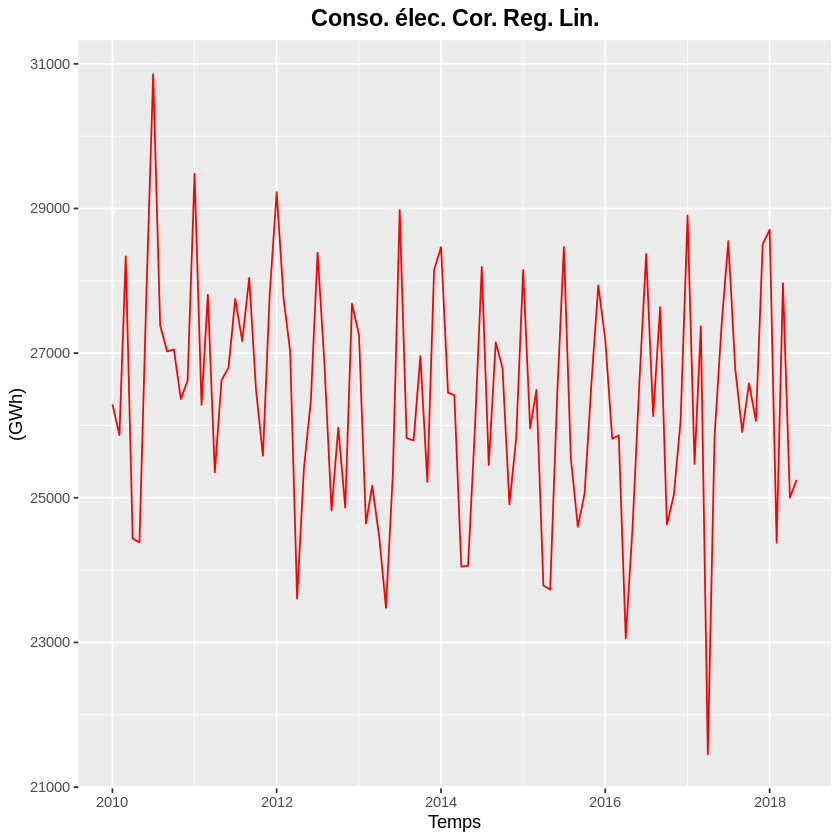

In [25]:
#Représentation de la conso, des DJU et de la conso corrigée de Janvier 2010 à Mai 2018
ggplot(conso) + 
geom_line(aes(Date, Conso_RL), color='red') +
ggtitle('Conso. élec. Cor. Reg. Lin.') +
xlab('Temps') +
ylab('(GWh)') + 
theme(plot.title = element_text(size=14, face='bold', hjust=0.5))

ggsave('graph/question_1/conso_RL.png')

# 3) Question 2: Desaisonnalisation par moyenne mobile

In [26]:
conso_RL.ts = ts(conso$Conso_RL, start=2010, freq=12)

# Avec la fonction decompose
decomp_u2 = decompose(conso_RL.ts, type='additive')

#Création d'une ts pour la date
x = ts(data=NA, start=2010, end=c(2018, 5), freq=12)

#Création d'un dataframe pour ggplot
moy_mob = data.frame(Date=as.Date(as.yearmon(time(x))),
                     Obs=as.matrix(decomp_u2$x),
                     Seas=as.matrix(decomp_u2$seasonal),
                     Trend=as.matrix(decomp_u2$trend),
                     Res=as.matrix(decomp_u2$random))

head(moy_mob, 7)

Date,Obs,Seas,Trend,Res
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-01,"26291,76","2035,50945",NA,NA
2010-02-01,"25866,93","-274,43341",NA,NA
2010-03-01,"28339,06","273,18708",NA,NA
2010-04-01,"24434,32","-2628,92015",NA,NA
2010-05-01,"24384,71","-1488,60069",NA,NA
2010-06-01,"27828,78","95,61491",NA,NA
2010-07-01,"30855,89","2287,04813","27003,49","1565,353"


In [27]:
#Préparation des données pour graph
moy_mob.residuals = decomp_u2[]$random
moy_mob.residuals.df = data.frame(Y=as.matrix(moy_mob.residuals), 
                                  date=as.Date(as.yearmon(time(moy_mob.residuals))))[c(-1,-2,-3,-4,-5,-6,-101,-100,-99,-98,-97,-96),]$Y

png 
  2

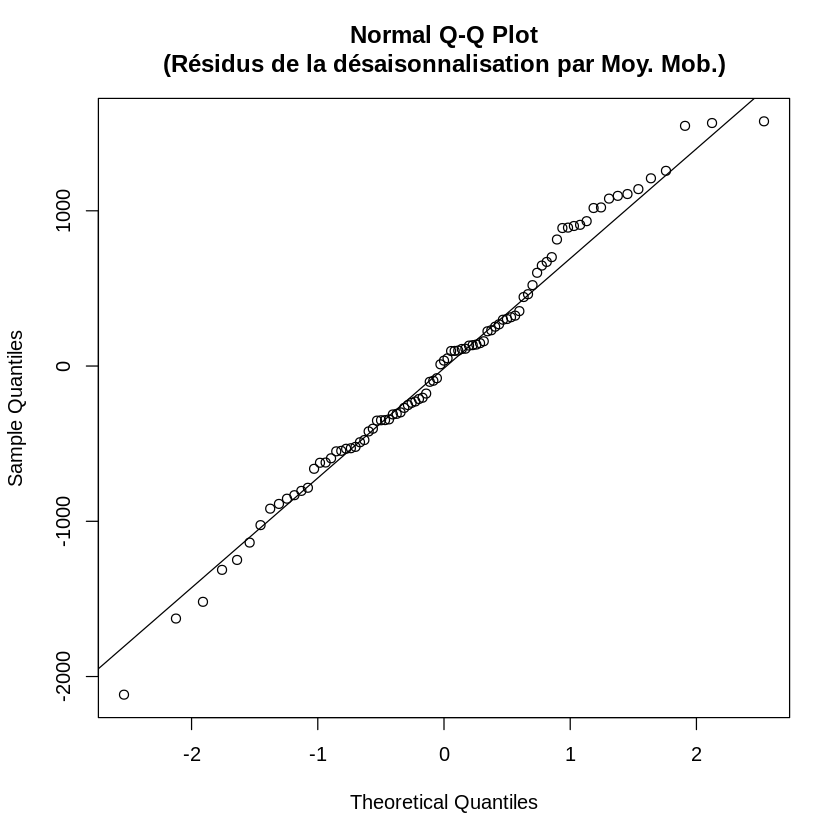

In [28]:
#Sauvegarde du graph
png('graph/question_1/qqplot_moy_mob.png')

qqnorm(moy_mob.residuals.df, main='Normal Q-Q Plot\n(Résidus de la désaisonnalisation par Moy. Mob.)')
qqline(moy_mob.residuals.df)
dev.off()

#Représentation Quantile-Quantile des résidus
qqnorm(moy_mob.residuals.df, main='Normal Q-Q Plot\n(Résidus de la désaisonnalisation par Moy. Mob.)')
qqline(moy_mob.residuals.df)

In [29]:
#Test de normalité des résidus
shapiro.test(moy_mob.residuals.df)


	Shapiro-Wilk normality test

data:  moy_mob.residuals.df
W = 0,98831, p-value = 0,6148


Warning message:
“Removed 12 rows containing missing values (geom_path).”Warning message:
“Removed 12 rows containing missing values (geom_path).”Saving 6,67 x 6,67 in image


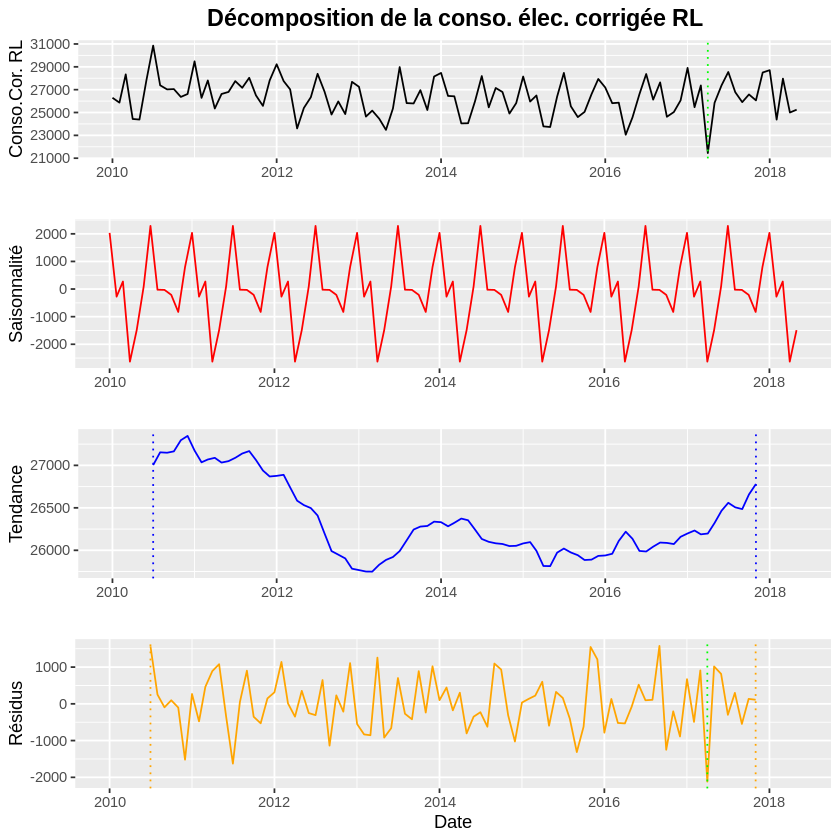

In [30]:
#Représentation de la décomposition de la conso. élec. cor.
g1 = ggplot(moy_mob) +
geom_line(aes(Date, Obs), colour='black') +
xlab('') +
ylab('Conso.Cor. RL') +
ggtitle('Décomposition de la conso. élec. corrigée RL') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5)) + 
geom_vline(aes(xintercept=as.numeric(moy_mob$Date[88])), col='green', linetype=3)

g2 = ggplot(moy_mob) +
geom_line(aes(Date, Seas), colour='red') +
xlab('') +
ylab('Saisonnalité')

g3 = ggplot(moy_mob) +
geom_line(aes(Date, Trend), colour='blue') +
xlab('') +
ylab('Tendance') + 
geom_vline(aes(xintercept=as.numeric(moy_mob$Date[7])), col='blue', linetype=3) + 
geom_vline(aes(xintercept=as.numeric(moy_mob$Date[95])), col='blue', linetype=3)

g4 = ggplot(moy_mob) +
geom_line(aes(Date, Res), colour='orange') +
ylab('Résidus') + 
geom_vline(aes(xintercept=as.numeric(moy_mob$Date[88])), col='green', linetype=3) +
geom_vline(aes(xintercept=as.numeric(moy_mob$Date[7])), col='orange', linetype=3) + 
geom_vline(aes(xintercept=as.numeric(moy_mob$Date[95])), col='orange', linetype=3)

g5 = grid.arrange(g1, g2, g3, g4, nrow = 4)

ggsave('graph/question_2/decomp_conso_cor_multi.png', g5)

Saving 6,67 x 6,67 in image


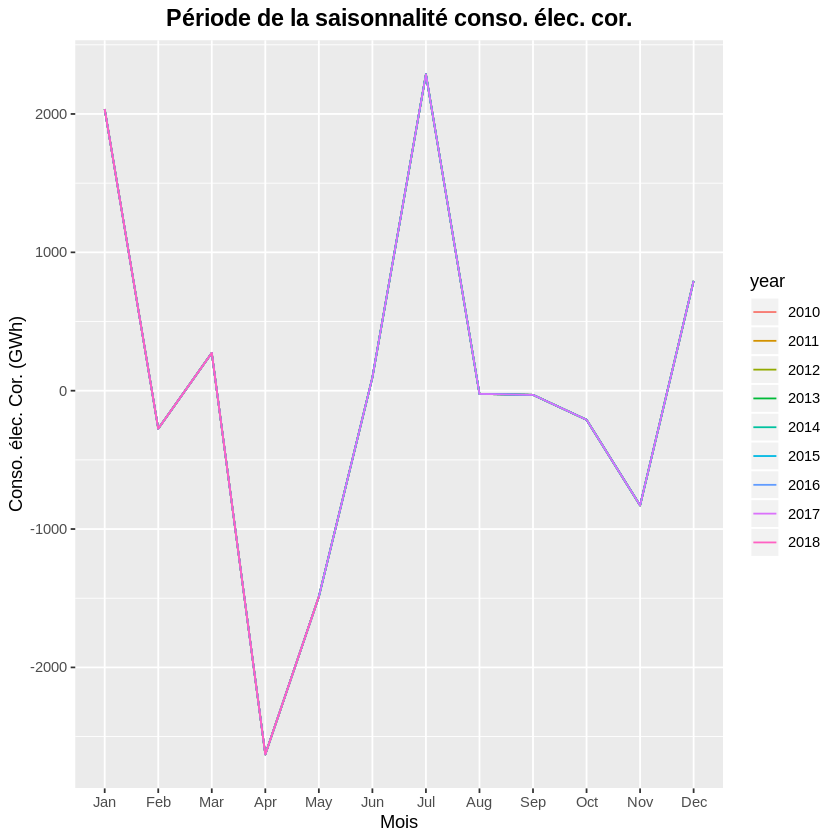

In [31]:
Seas.ts = ts(moy_mob$Seas, start=2010, freq=12)

#Graphique de période de la saisonnalité de la conso. élec. cor. 
ggseasonplot(Seas.ts) + 
xlab('Mois') +
ylab('Conso. élec. Cor. (GWh)') +
labs(title='Période de la saisonnalité conso. élec. cor.') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5))

ggsave('graph/question_2/periode_sais_conso_cor.png')

In [32]:
#Correction par moyenne mobile
conso$Conso_MM = conso$Conso_RL - decomp_u2$seasonal

head(conso)

Date,Conso,dju,Conso_RL,Conso_MM
<date>,<int>,<dbl>,<dbl>,<dbl>
2010-01-01,56342,"624,8","26291,76","24256,25"
2010-02-01,48698,"474,7","25866,93","26141,37"
2010-03-01,48294,"414,9","28339,06","28065,87"
2010-04-01,38637,"295,3","24434,32","27063,24"
2010-05-01,37284,"268,2","24384,71","25873,31"
2010-06-01,34567,"140,1","27828,78","27733,17"


Saving 6,67 x 6,67 in image


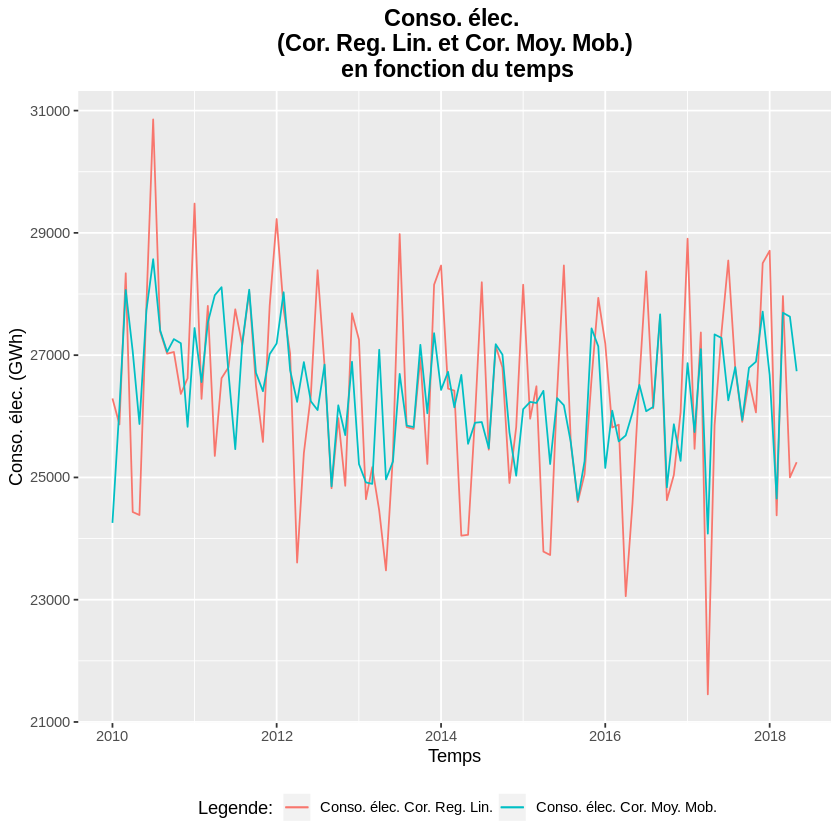

In [33]:
#Représentation de la cons.élec. cor. et de la conso. élec. désaisonnalisée 
ggplot(conso) + 
geom_line(aes(Date, Conso_RL, colour='A')) +
geom_line(aes(Date, Conso_MM, colour='B')) +
scale_color_discrete(name='Legende:',
                    labels=c('Conso. élec. Cor. Reg. Lin.',
                             'Conso. élec. Cor. Moy. Mob.')) +
ggtitle('Conso. élec. \n (Cor. Reg. Lin. et Cor. Moy. Mob.) \n en fonction du temps') +
xlab('Temps') +
ylab('Conso. élec. (GWh)') + 
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') 



ggsave('graph/question_2/conso_RL_conso_MM_unique.png')

Saving 6,67 x 6,67 in image


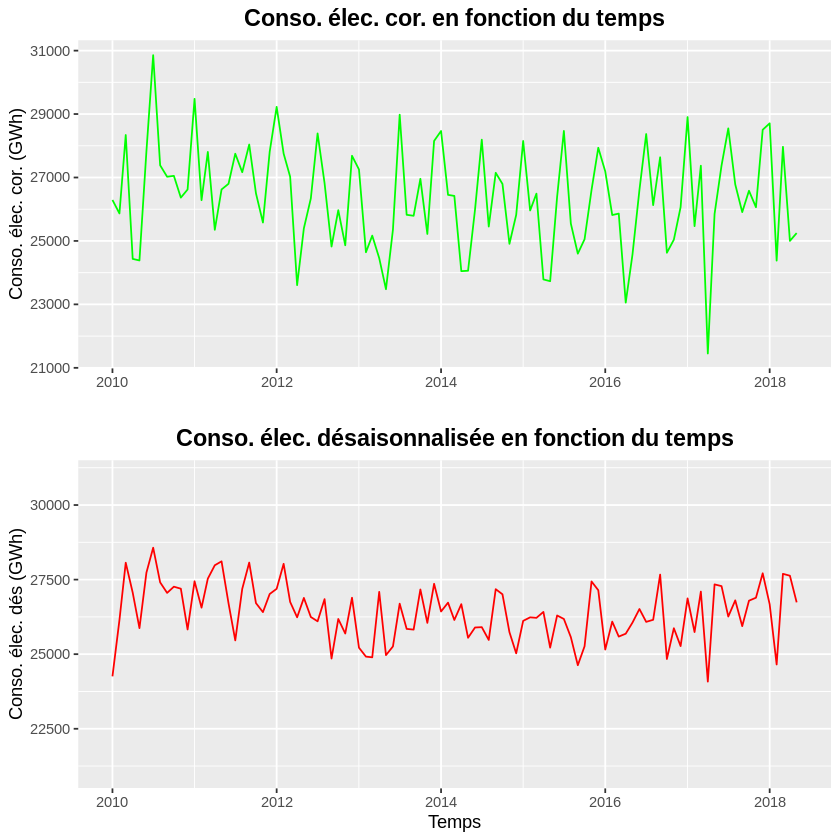

In [34]:
#Représentation de la cons.élec. cor. et de la conso. élec. désaisonnalisée l'une sous l'autre
q1 = ggplot(conso) +
geom_line(aes(Date, Conso_RL), colour='green') + 
ggtitle('Conso. élec. cor. en fonction du temps') +
xlab('') +
ylab('Conso. élec. cor. (GWh)') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5))

q2 = ggplot(conso) + 
geom_line(aes(Date, Conso_MM), colour ='red') +
ggtitle('Conso. élec. désaisonnalisée en fonction du temps') +
xlab('Temps') +
ylab('Conso. élec. dés (GWh)') + theme(plot.title = element_text(size=14, face='bold', hjust=0.5)) +
ylim(21000, 31000)


q3 =grid.arrange(q1, q2, nrow = 2)

ggsave('graph/question_2/conso_cor_conso_des.png', q3)

Warning message:
“Removed 12 rows containing missing values (geom_path).”Saving 6,67 x 6,67 in image
Warning message:
“Removed 12 rows containing missing values (geom_path).”

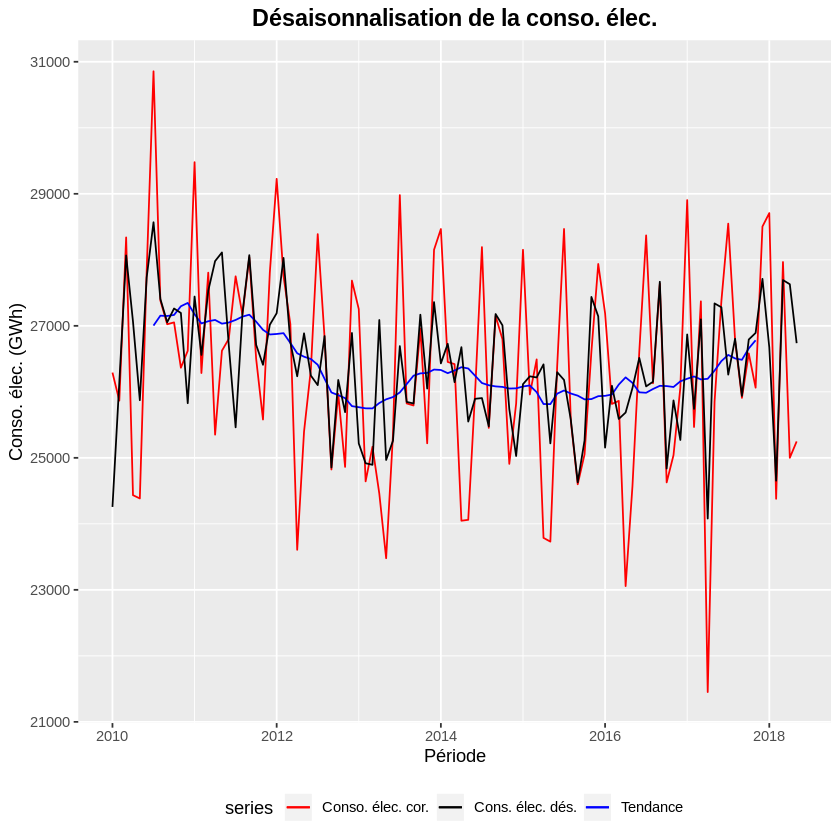

In [35]:
#Représentation de la conso. élec. cor., désaisonalisée, et de la tendance
autoplot(decomp_u2$x, series='Conso. élec. cor.') +
autolayer(trendcycle(decomp_u2), series='Tendance') +
autolayer(seasadj(decomp_u2), series='Cons. élec. dés.') +
ylab('Conso. élec. (GWh)') +
xlab('Période') +
ggtitle('Désaisonnalisation de la conso. élec.') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') + 
scale_colour_manual(values=c('black', 'red', 'blue'), breaks=c('Conso. élec. cor.', 'Cons. élec. dés.', 'Tendance'))

ggsave('graph/question_2/decomp_conso_cor_superpose.png')

# 3) Question 3: Prévisions

## 3) a) Par la méthode Holt-Winters

In [36]:
#Identification a priori du modèle
#Lissage exponentiel méthode Holt-Winters
hw = HoltWinters(conso_RL.ts)

hw

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = conso_RL.ts)

Smoothing parameters:
 alpha: 0,09291335
 beta : 0
 gamma: 0,3053753

Coefficients:
            [,1]
a   26596,914494
b      -8,484644
s1    332,563061
s2   2337,555117
s3      1,476620
s4    -16,193093
s5   -317,916569
s6   -652,497018
s7    978,335830
s8   2053,198451
s9   -941,158101
s10   689,533228
s11 -2654,109534
s12 -1314,676535

In [37]:
#Préparation des données pour estimation
time = time(conso_RL.ts)

n.valid = 12
n.train = length(conso_RL.ts) - n.valid
train.ts = window(conso_RL.ts, start=time[1], end=time[n.train])
valid.ts = window(conso_RL.ts, start=time[n.train+1], end=time[n.train+n.valid])

Saving 6,67 x 6,67 in image


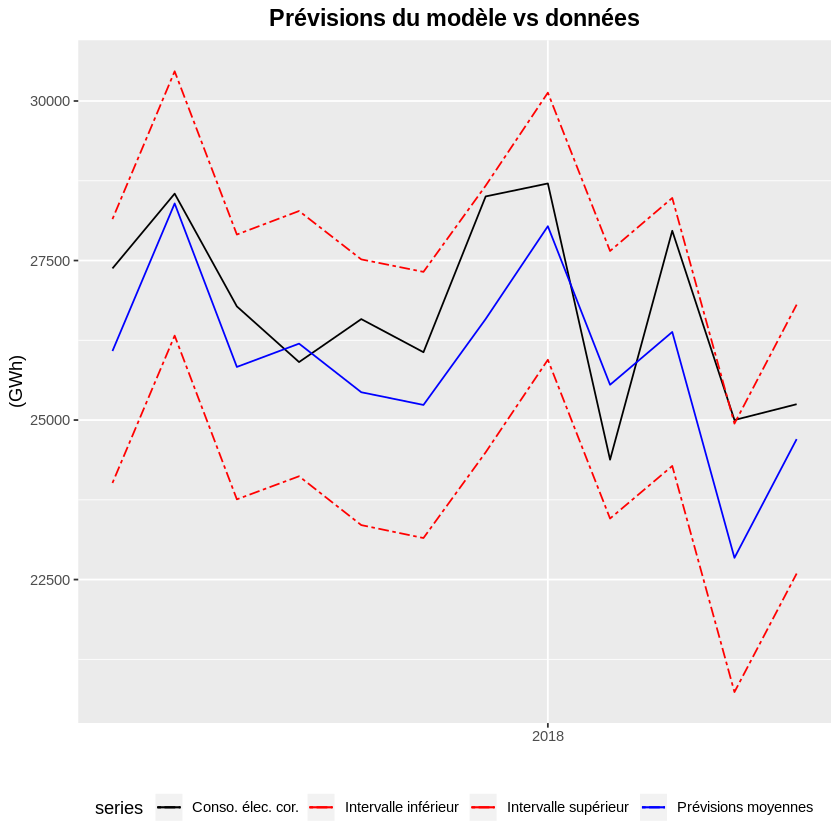

In [38]:
#Modélisation sur les données d'entrainnements
hw1 = HoltWinters(train.ts)

#Prévisions sur un an
valid_model = forecast(hw1, h=12, level=95)

#Représentation de la conso. élec. cor., des prévisions et des intervalles
autoplot(valid.ts, series='Conso. élec. cor.') +
autolayer(ts(forecast(hw1, h=12, level=95)$mean, start=c(2017,6), freq=12),
          series='Prévisions moyennes') +
autolayer(ts(forecast(hw1, h=12, level=95)$lower, start=c(2017,6), freq=12),
          series='Intervalle inférieur',
          linetype='twodash') +
autolayer(ts(forecast(hw1, h=12, level=95)$upper, start=c(2017,6), freq=12),
          series='Intervalle supérieur',
          linetype='twodash') +
ylab('(GWh)') +
xlab('') +
ggtitle('Prévisions du modèle vs données') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') +
scale_color_manual(values=c('black', 'red', 'red', 'blue'))

ggsave('graph/question_3/prev_hw.png')

In [39]:
#Root Mean Square Error (erreur quadratique moyenne)
rmse_hw = sqrt(mean((valid.ts-valid_model$mean)^2))
rmse_hw

[1] 1213,618

In [40]:
#Mean Average Percentage Error (erreur relative absolue moyenne)
mape_hw = mean(abs(1-valid_model$mean/valid.ts))*100
mape_hw

[1] 3,980731

Saving 6,67 x 6,67 in image


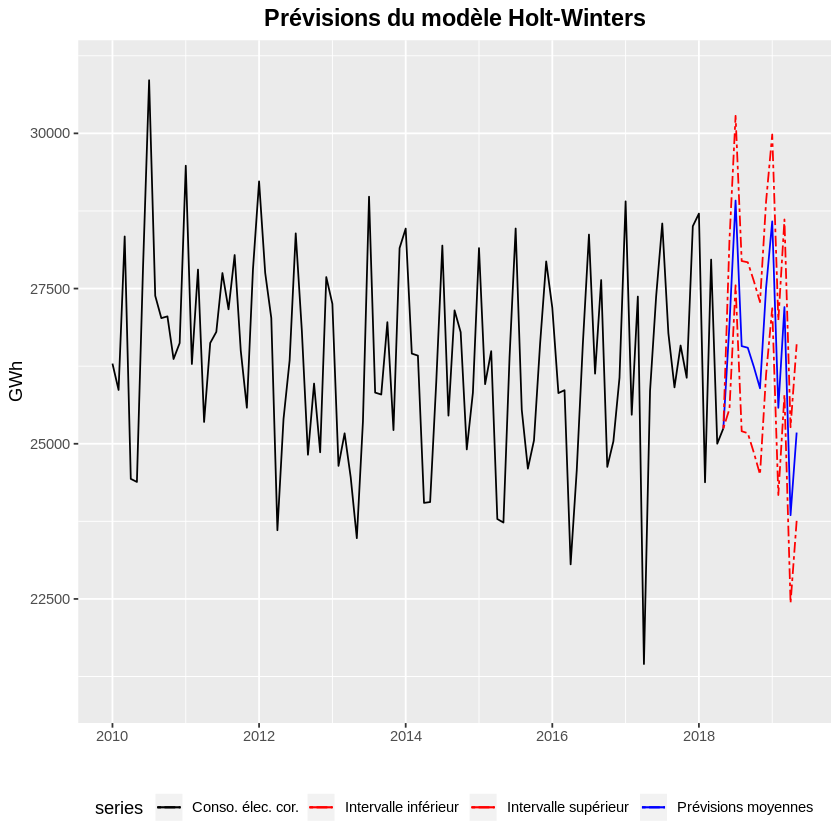

In [41]:
#Prévisions sur un an sur toutes nos données avec le modèle choisi
conso_pred = forecast(hw, h=12)

#Préparation des données pour visualisation
model_pred = ts(c(conso$Conso_RL[101], conso_pred$mean),
                start=c(2018, 5),
                end=c(2019,5),
                frequency=12)

model_pred_low = ts(c(conso$Conso_RL[101], conso_pred$lower),
                    start=c(2018, 5),
                    end=c(2019,5),
                    frequency=12)

model_pred_high = ts(c(conso$Conso_RL[101], conso_pred$upper), 
                    start=c(2018, 5),
                    end=c(2019,5),
                    frequency=12)

#Représentation des prévisions
autoplot(conso_RL.ts, series='Conso. élec. cor.') +
autolayer(model_pred, series='Prévisions moyennes') +
autolayer(model_pred_low, series='Intervalle inférieur', linetype='twodash') +
autolayer(model_pred_high, series='Intervalle supérieur', linetype='twodash') +
ylab(('GWh')) +
xlab('') +
ylim(c(21000, 31000)) +
ggtitle('Prévisions du modèle Holt-Winters') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') +
scale_color_manual(values=c('black', 'red', 'red', 'blue'))

ggsave('graph/question_3/prev_hw2.png')

Saving 6,67 x 6,67 in image


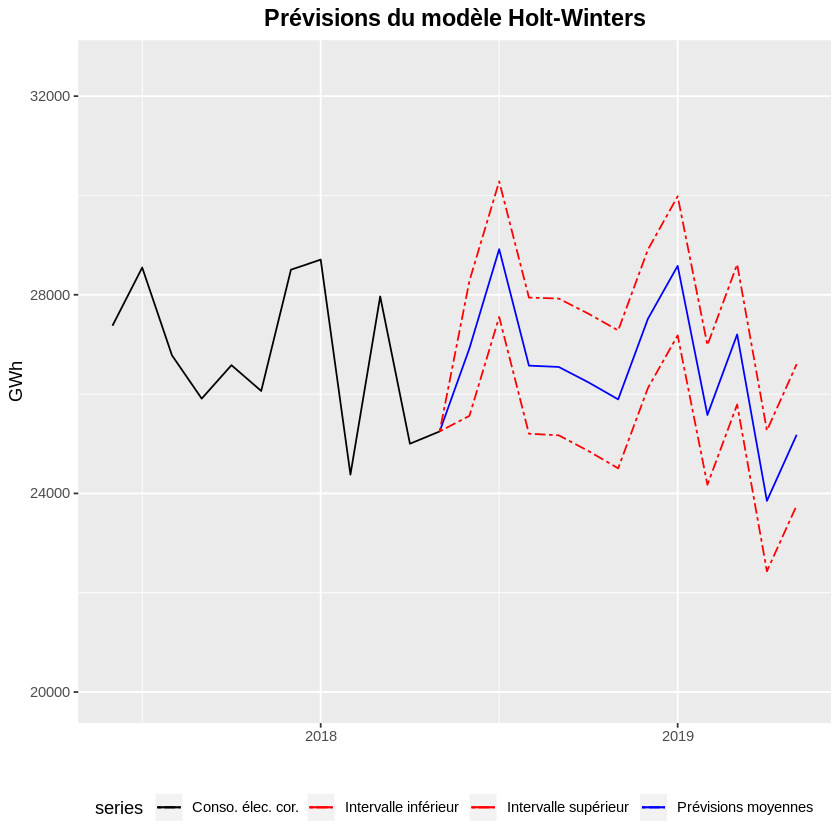

In [42]:
#Zoom sur les prévisions
autoplot(window(conso_RL.ts, start=c(2017, 6)), series='Conso. élec. cor.') +
autolayer(model_pred, series='Prévisions moyennes') +
autolayer(model_pred_low, series='Intervalle inférieur', linetype='twodash') +
autolayer(model_pred_high, series='Intervalle supérieur', linetype='twodash') +
ylab(('GWh')) +
xlab('') +
ylim(c(20000, 32500)) +
ggtitle('Prévisions du modèle Holt-Winters') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') +
scale_color_manual(values=c('black', 'red', 'red', 'blue'))

ggsave('graph/question_3/prev_hw2_zoom.png')

## 3) b) Par la méthode SARIMA

png 
  2

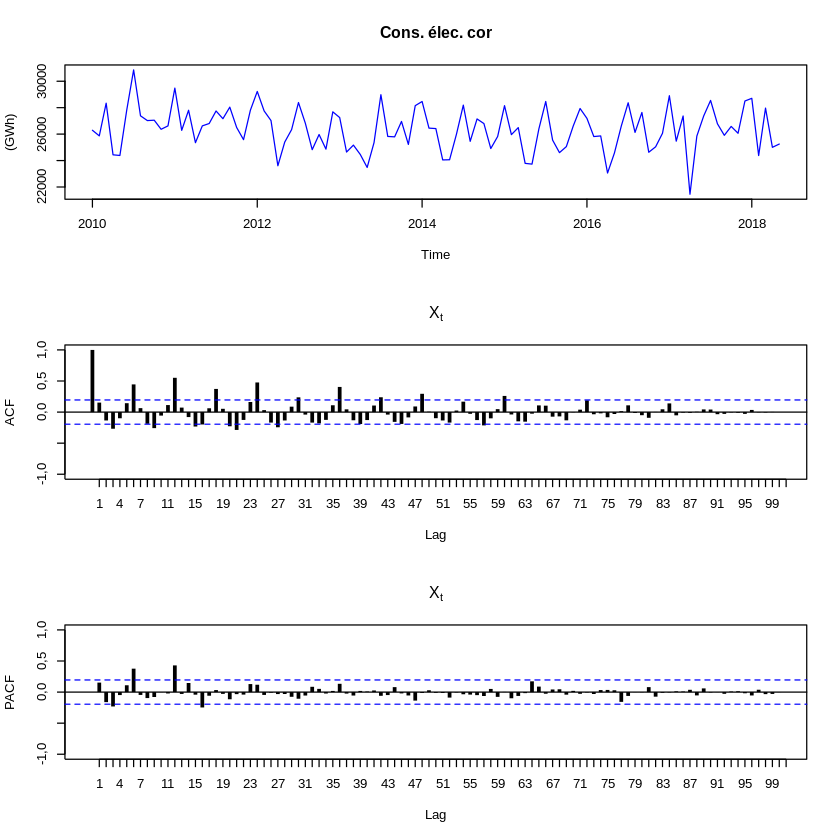

In [43]:
nlag = length(conso_RL.ts)
sais = 12

#Autocorrélogramme si le processus est stationnaire
acf = (acf(conso$Conso_RL, lag.max=nlag, plot=F))
pacf = (pacf(conso$Conso_RL, lag.max=nlag, plot=F))

#Sauvegarde du graph
png('graph/question_3/acf_conso_cor.png')

par(mfrow=c(3,1))

plot(conso_RL.ts,
     main='Cons. élec. cor',
     ylab='(GWh)',
     col='blue')
plot(acf,
     ci=0.95,
     xlim=c(0, nlag-1),
     ylim=c(-1,1),
     xaxp=c(1, nlag,nlag-1),
     type='h',
     lend='butt',
     lwd=3,
     xlab='Lag',
     ylab='ACF',
     main=TeX('$X_t$'))
plot(pacf,
     ci=0.95,
     xlim=c(0, nlag-1),
     ylim=c(-1,1),
     xaxp=c(1, nlag, nlag-1),
     type='h',
     lend='butt',
     lwd=3,
     xlab='Lag',
     ylab=TeX('PACF'),
     main=TeX('$X_t$$'))

dev.off()

#Visualisation
par(mfrow=c(3,1))

plot(conso_RL.ts,
     main='Cons. élec. cor',
     ylab='(GWh)',
     col='blue')
plot(acf,
     ci=0.95,
     xlim=c(0, nlag-1),
     ylim=c(-1,1),
     xaxp=c(1, nlag,nlag-1),
     type='h',
     lend='butt',
     lwd=3,
     xlab='Lag',
     ylab='ACF',
     main=TeX('$X_t$'))
plot(pacf,
     ci=0.95,
     xlim=c(0, nlag-1),
     ylim=c(-1,1),
     xaxp=c(1, nlag, nlag-1),
     type='h',
     lend='butt',
     lwd=3,
     xlab='Lag',
     ylab=TeX('PACF'),
     main=TeX('$X_t$$'))

png 
  2

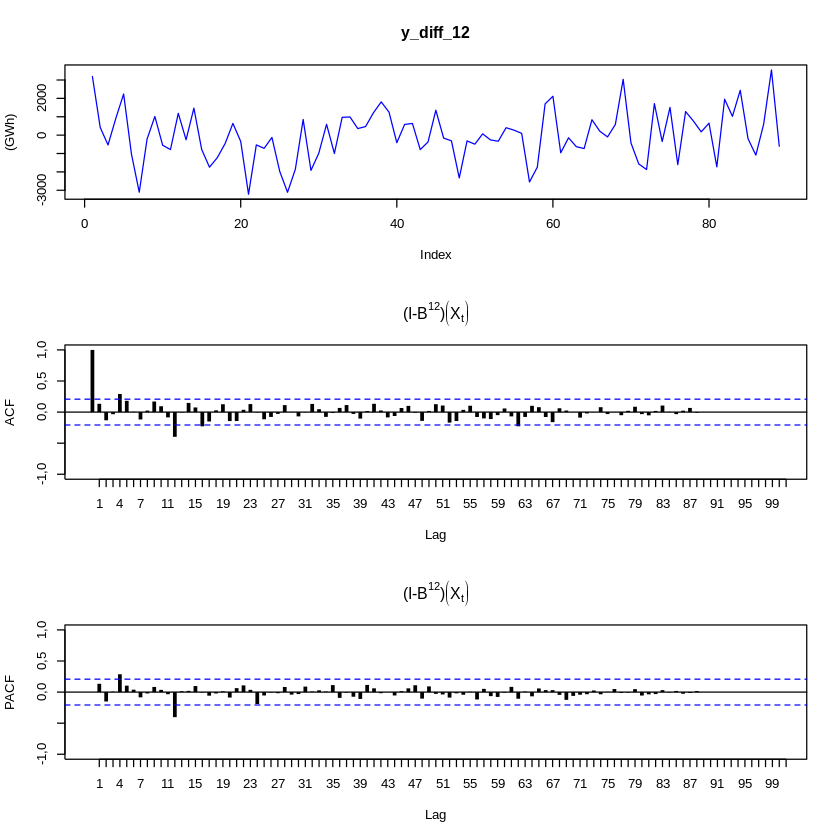

In [44]:
#Difference d'ordre 12
y_dif_12 = diff(conso$Conso_RL, lag=12, differences=1)

#Autocorrélogramme si le processus est stationnaire
acf = (acf(y_dif_12, lag.max=nlag, plot=F))
pacf = (pacf(y_dif_12, lag.max=nlag, plot=F))

#Sauvegarde du graph
png('graph/question_3/acf_conso_cor_diff12.png')

par(mfrow=c(3,1))

plot(y_dif_12,
     main='y_diff_12',
     ylab='(GWh)',
     col='blue',
     type='l')
plot(acf,
     ci=0.95,
     xlim=c(0, nlag-1),
     ylim=c(-1,1),
     xaxp=c(1, nlag,nlag-1),
     type='h',
     lend='butt',
     lwd=3,
     xlab='Lag',
     ylab='ACF',
     main=TeX('$(I-B^{12})\\left(X_t\\right)$'))
plot(pacf,
     ci=0.95,
     xlim=c(0, nlag-1),
     ylim=c(-1,1),
     xaxp=c(1, nlag, nlag-1),
     type='h',
     lend='butt',
     lwd=3,
     xlab='Lag',
     ylab=TeX('PACF'),
     main=TeX('$(I-B^{12})\\left(X_t\\right)$'))

dev.off()

#Visualisation
par(mfrow=c(3,1))

plot(y_dif_12,
     main='y_diff_12',
     ylab='(GWh)',
     col='blue',
     type='l')
plot(acf,
     ci=0.95,
     xlim=c(0, nlag-1),
     ylim=c(-1,1),
     xaxp=c(1, nlag,nlag-1),
     type='h',
     lend='butt',
     lwd=3,
     xlab='Lag',
     ylab='ACF',
     main=TeX('$(I-B^{12})\\left(X_t\\right)$'))
plot(pacf,
     ci=0.95,
     xlim=c(0, nlag-1),
     ylim=c(-1,1),
     xaxp=c(1, nlag, nlag-1),
     type='h',
     lend='butt',
     lwd=3,
     xlab='Lag',
     ylab=TeX('PACF'),
     main=TeX('$(I-B^{12})\\left(X_t\\right)$'))

In [45]:
#Modèle avec sélection automatique des paramètres
model_auto = auto.arima(conso_RL.ts)
summary(model_auto)

Series: conso_RL.ts 
ARIMA(1,0,1)(2,1,0)[12] 

Coefficients:
         ar1      ma1     sar1     sar2
      0,9558  -0,8528  -0,7761  -0,3967
s.e.  0,0535   0,0843   0,1144   0,1172

sigma^2 estimated as 1201440:  log likelihood=-751,3
AIC=1512,61   AICc=1513,33   BIC=1525,05

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1,028628 1005,541 763,8856 -0,1087279 2,923388 0,7106783
                    ACF1
Training set -0,02477632


In [46]:
#Test de significativité des paramètres
t_stat(model_auto)

,ar1,ma1,sar1,sar2
t.stat,"17,87452","-10,12023","-6,78624","-3,384767"
p.val,"0,00000","0,00000","0,00000","0,000712"


In [47]:
#Test de blancheur des résidus
Box.test.2(model_auto$residuals, nlag=seq(6, 84, 6), type='Ljung-Box', decim=5)

Retard,p-value
6,"0,65804"
12,"0,86661"
18,"0,86453"
24,"0,83714"
30,"0,92539"
36,"0,95389"
42,"0,95348"
48,"0,97796"
54,"0,98850"
60,"0,99502"


In [48]:
#Test de normalité des résidus
shapiro.test(model_auto$residuals)


	Shapiro-Wilk normality test

data:  model_auto$residuals
W = 0,9858, p-value = 0,3549


Saving 6,67 x 6,67 in image


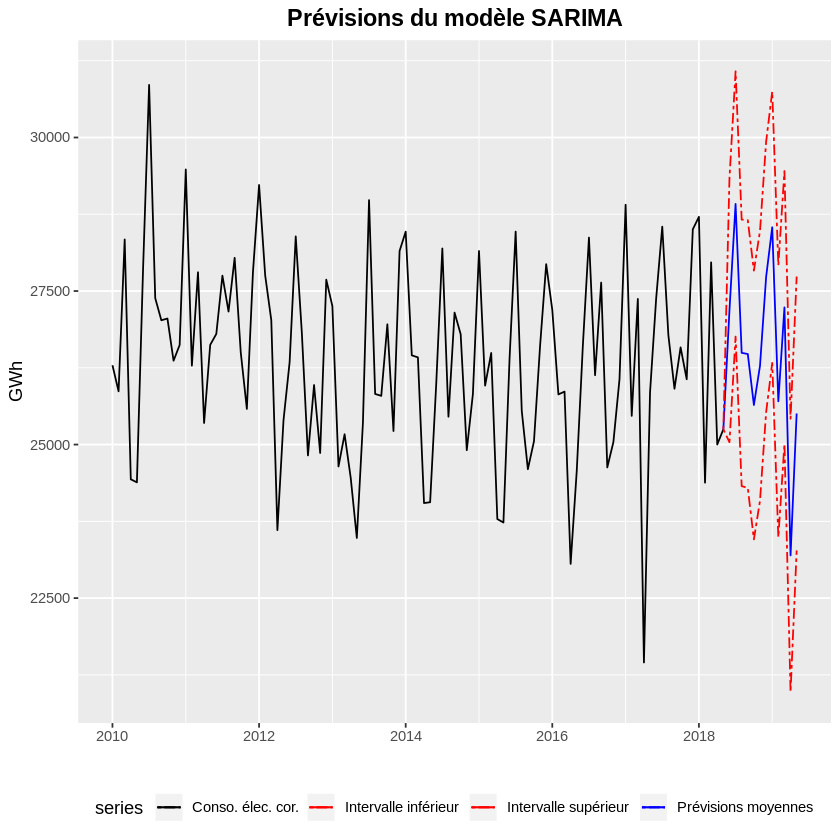

In [49]:
#Prévisions sur un an sur toutes nos données avec le modèle choisi
pred_model_auto = forecast(model_auto, h=12, level=95)

#Préparation des données pour visualisation
pred_auto = ts(c(conso$Conso_RL[101], pred_model_auto$mean),
               start=c(2018, 5),
               frequency=12)

pred_high_auto = ts(c(conso$Conso_RL[101], pred_model_auto$lower),
                    start=c(2018, 5),
                    frequency=12)

pred_low_auto = ts(c(conso$Conso_RL[101], pred_model_auto$upper),
                   start=c(2018, 5),
                   frequency=12)

#Représentation des prévisions
autoplot(conso_RL.ts, series='Conso. élec. cor.') +
autolayer(pred_auto, series='Prévisions moyennes') +
autolayer(pred_high_auto, series='Intervalle inférieur', linetype='twodash') +
autolayer(pred_low_auto, series='Intervalle supérieur', linetype='twodash') +
ylab(('GWh')) +
xlab('') +
ggtitle('Prévisions du modèle SARIMA') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') +
scale_color_manual(values=c('black', 'red', 'red', 'blue'))

ggsave('graph/question_3/prev_sarima_auto.png')

Saving 6,67 x 6,67 in image


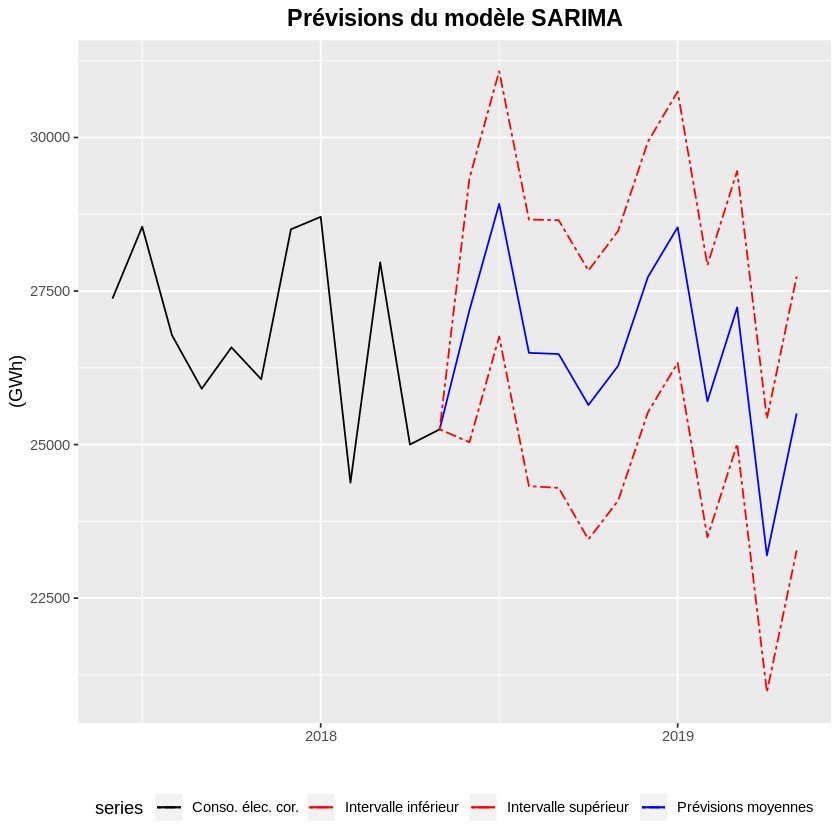

In [50]:
#Représentation des prévisions
autoplot(window(valid.ts), series='Conso. élec. cor.') +
autolayer(pred_auto, series='Prévisions moyennes') +
autolayer(pred_high_auto, series='Intervalle inférieur', linetype='twodash') +
autolayer(pred_low_auto, series='Intervalle supérieur', linetype='twodash') +
ylab('(GWh)') +
xlab('') +
ggtitle('Prévisions du modèle SARIMA') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') +
scale_color_manual(values=c('black', 'red', 'red', 'blue'))

ggsave('graph/question_3/prev_sarima_zoom_auto.png')

In [51]:
#Modèle tronqué pour comparaison de modèles
model_auto_tronc = Arima(train.ts, order=c(1,0,1), list(order=c(2,1,0), period=12), include.mean=F, method='CSS-ML')
summary(model_auto_tronc)

Series: train.ts 
ARIMA(1,0,1)(2,1,0)[12] 

Coefficients:
         ar1      ma1     sar1     sar2
      0,9570  -0,8739  -0,7375  -0,4182
s.e.  0,0645   0,1042   0,1296   0,1282

sigma^2 estimated as 1205191:  log likelihood=-650,32
AIC=1310,65   AICc=1311,49   BIC=1322,37

Training set error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set -75,66692 994,2472 746,2446 -0,4003406 2,864218 0,7103645
                    ACF1
Training set -0,03815482


In [52]:
#Test de significativité des paramètres
t_stat(model_auto_tronc)

,ar1,ma1,sar1,sar2
t.stat,"14,83014","-8,3871","-5,691299","-3,260531"
p.val,"0,00000","0,0000","0,000000","0,001112"


In [53]:
#Test de blancheur des résidus
Box.test.2(model_auto_tronc$residuals, nlag=seq(6, 84, 6), type='Ljung-Box', decim=5)

Retard,p-value
6,"0,53225"
12,"0,62732"
18,"0,73302"
24,"0,78661"
30,"0,87507"
36,"0,92274"
42,"0,92614"
48,"0,95753"
54,"0,97852"
60,"0,99179"


In [54]:
#Test de normalité des résidus
shapiro.test(model_auto_tronc$residuals)


	Shapiro-Wilk normality test

data:  model_auto_tronc$residuals
W = 0,98628, p-value = 0,4753


Saving 6,67 x 6,67 in image


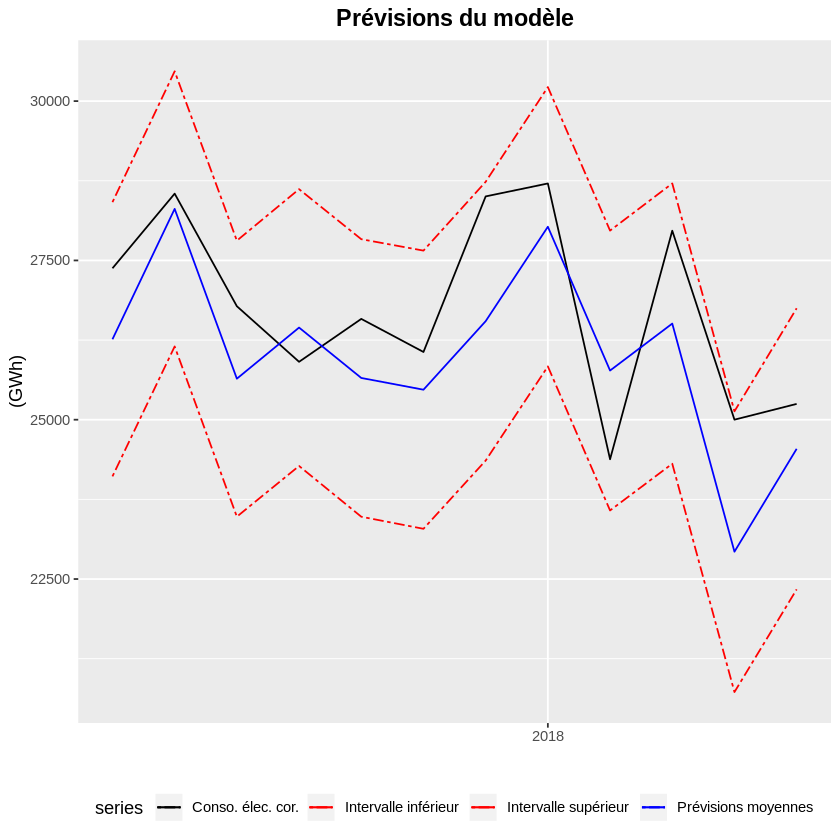

In [55]:
#Prévisions sur un an sur toutes nos données avec le modèle choisi
pred_model_auto_tronc = forecast(model_auto_tronc, h=12, level=95)

#Préparation des données pour visualisation
pred_auto_tronc = pred_model_auto_tronc$mean
pred_auto_high_tronc = pred_model_auto_tronc$upper
pred_auto_low_tronc = pred_model_auto_tronc$lower

#Représentation des prévisions
autoplot(window(valid.ts), series='Conso. élec. cor.') +
autolayer(pred_auto_tronc, series='Prévisions moyennes') +
autolayer(pred_auto_high_tronc, series='Intervalle inférieur', linetype='twodash') +
autolayer(pred_auto_low_tronc, series='Intervalle supérieur', linetype='twodash') +
ylab('(GWh)') +
xlab('') +
ggtitle('Prévisions du modèle') +
theme(plot.title = element_text(size=14, face='bold', hjust=0.5), legend.position='bottom') +
scale_color_manual(values=c('black', 'red', 'red', 'blue'))

ggsave('graph/question_3/prev_sarima_zoom_tronc_auto.png')

In [56]:
#Root Mean Square Error (erreur quadratique moyenne)
rmse_sar = sqrt(mean((valid.ts-pred_auto_tronc)^2))
rmse_sar

[1] 1198,531

In [57]:
#Mean Average Percentage Error (erreur relative absolue moyenne)
mape_sar = mean(abs(1-pred_auto_tronc/valid.ts))*100
mape_sar

[1] 4,018604